<a href="https://colab.research.google.com/github/mgfrantz/CTME-llm-lecture-resources/blob/main/prototyping_ai/02_rag_and_agents_solution_12072024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval Augmented Generation

![](https://www.dailydoseofds.com/content/images/2024/10/rag.gif)
Source: [Daily Dose of DS](https://www.dailydoseofds.com/a-crash-course-on-building-rag-systems-part-1-with-implementations/)

In [1]:
%load_ext rich
%load_ext autoreload
%autoreload 2

# Introduction to RAG with LlamaIndex

LlamaIndex is a library for working with large language models.
One of its main strengths is its ability to ingest documents into a vector index and use them to answer questions.
This is known as Retrieval Augmented Generation (RAG).

To start, we will use a low-code, high-level abstraction to build a basic PDF question-answering system.
We will read in PDFs, split them into chunks, embed them, and store them in a vector database.
Then, we will use an abstraction known as a `QueryEngine` that implements RAG to answer questions about the documents.

In [2]:
# If we're in colab, use userdata to get the OPENAI_API_KEY
# In colab, you will need to restart the session after running this cell
# or you will get a PIL error when doing LLM inference.
import os
from rich import print
from pathlib import Path

try:
    from google.colab import userdata
    print("Colab detected - setting up environment")
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    %pip install -qqqq llama-index \
        "openai==1.55.3" \
        "httpx==0.27.2" \
        llama-index-readers-web \
        thefuzz \
        gradio \
        chromadb \
        llama-index-embeddings-huggingface \
        llama-index-vector-stores-chroma \
        llama-index-retrievers-bm25 \
        llama-index-llms-gemini \
        docling \
        llama-index-readers-docling \
        llama-index-node-parser-docling \
        llama-index-utils-workflow \
        llama-index-tools-yahoo-finance \
        llama-index-tools-code-interpreter

except:
    print("Not in colab - using local environment variables.")
    from dotenv import load_dotenv
    load_dotenv("../.env")


Colab detected - setting up environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 81.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.

In [1]:
import os
import requests

try:
    from google.colab import userdata
    print("Colab detected - setting up environment")
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
except:
    load_dotenv("../.env")

# Create data directory if it doesn't exist
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download the PDF file
llama3_url = "https://arxiv.org/pdf/2407.21783"
# llama2_url = "https://arxiv.org/pdf/2307.09288"
llama3_path = os.path.join(data_dir, "llama3.pdf")
# llama2_path = os.path.join(data_dir, "llama2.pdf")

if not os.path.exists(llama3_path):
    response = requests.get(llama3_url)
    with open(llama3_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded PDF to {llama3_path}")
else:
    print(f"PDF already exists at {llama3_path}")

# if not os.path.exists(llama2_path):
#     response = requests.get(llama2_url)
#     with open(llama2_path, "wb") as f:
#         f.write(response.content)
#     print(f"Downloaded PDF to {llama2_path}")
# else:
#     print(f"PDF already exists at {llama2_path}")


Colab detected - setting up environment
PDF already exists at data/llama3.pdf


The first thing we need to do is to load the data.
For general documents like PDFs, LlamaIndex provides a nice abstraction known as a `SimpleDirectoryReader` that can load data from a directory.
In the cell below, we use it to load the data from the `data` directory.

In [2]:
from llama_index.core.readers import SimpleDirectoryReader
documents = SimpleDirectoryReader(data_dir).load_data()

Let's take a look at the first document.
Most prominently, we get the text of the document.
By default, we also get a lot of useful information, like the page number file name, file path, type, size, etc.
When we load lots of documents, this type of information becomes important to keep track of.

In [3]:
print(documents[0])

Doc ID: ce70be30-5c52-43e6-a180-5ed92b4085f2
Text: The Llama 3 Herd of Models Llama Team, AI @ Meta 1 1A detailed
contributor list can be found in the appendix of this paper. Modern
artificial intelligence (AI) systems are powered by foundation models.
This paper presents a new set of foundation models, called Llama 3. It
is a herd of language models that natively support multilinguality,
coding...


In [4]:
documents[0].metadata

{'page_label': '1',
 'file_name': 'llama3.pdf',
 'file_path': '/content/data/llama3.pdf',
 'file_type': 'application/pdf',
 'file_size': 9833173,
 'creation_date': '2024-12-07',
 'last_modified_date': '2024-12-07'}

Now that we've loaded the data, we need to vectorize it.
We will use a combination of an embedding model and a vector database to store the vectors.
In the cell below, we use a HuggingFace embedding model to embed the documents.
We also use torch to determine the device to use for the embedding model (`mps` for Mac GPUs, `cuda` for Nvidia GPUs, and `cpu` otherwise).

In [5]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from torch.backends.mps import is_available as is_mps_available
from torch.cuda import is_available as is_cuda_available

if is_mps_available():
    device = "mps"
elif is_cuda_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-large-en-v1.5", device=device)
index = VectorStoreIndex.from_documents(documents, embed_model=embed_model)

Using cuda


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Finally, let's set up our RAG query engine.
If we want to perform simple question-answering, we can use the `as_query_engine` method.
If we want to perform chat with history, we can use the `as_chat_engine` method.
We can see both below 👇.


In [6]:
from llama_index.llms.openai import OpenAI
# from llama_index.core import Settings
llm = OpenAI(model="gpt-4o-mini")
# Settings.llm = llm # set gpt-4o-mini as the default llm

query_engine = index.as_query_engine(llm=llm)
chat_engine = index.as_chat_engine(llm=llm)

Let's see how the query enine works.
We start by passing it a question, then it uses the retriever to find the most relevant documents.
Finally, it uses the LLM to answer the question.

In [7]:
response = query_engine.query("How many new Llama models models are mentioned in the llama3 paper?")

Below we see the response text.
But there's also some additional information that we can access, including the source nodes.
These are the nodes that the retriever used to answer the question.
We can see that the retriever found several nodes that are relevant to the question, then the LLM used at least one of them to answer the question.

In [8]:
print(response.response)

The paper mentions three new Llama models: Llama 3 with 8B, 70B, and 405B parameters.


Taking a look at the first source node, we can see that it is a node that contains part of the document that is relevant to the question.
It also contains the `score`, which is the similarity between the question and the node.


In [9]:
print(response.source_nodes[0])

Node ID: 87d3a95c-0a62-4733-a1ad-cdfbf2456e29
Text: The Llama 3 Herd of Models Llama Team, AI @ Meta 1 1A detailed
contributor list can be found in the appendix of this paper. Modern
artificial intelligence (AI) systems are powered by foundation models.
This paper presents a new set of foundation models, called Llama 3. It
is a herd of language models that natively support multilinguality,
coding...
Score:  0.773



In [10]:
len(response.source_nodes)

2

In [11]:
print(query_engine.get_prompts())

{'response_synthesizer:text_qa_template': SelectorPromptTemplate(metadata={'prompt_type': <PromptType.QUESTION_ANSWER: 'text_qa'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings={}, function_mappings={}, default_template=PromptTemplate(metadata={'prompt_type': <PromptType.QUESTION_ANSWER: 'text_qa'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, template='Context information is below.\n---------------------\n{context_str}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {query_str}\nAnswer: '), conditionals=[(<function is_chat_model at 0x784a45040790>, ChatPromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['context_str', 'query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, message_templates=[ChatMessage(role=<MessageRole.

Now let's see if our chat enigine comes up with the same answer.

In [12]:
chat_response = chat_engine.chat("How many new Llama models models are mentioned in the llama3 paper?")
print(chat_response.response)
print(chat_response.source_nodes[0])

The Llama 3 paper mentions three new Llama models: Llama 3 8B, Llama 3 70B, and Llama 3 405B.
Node ID: d5ae3d00-758c-4bb9-bfc8-b955a25256fc
Text: Finetuned Multilingual Long context Tool use Release Llama 3 8B
✗ ✗ 1 ✗ ✗ April 2024 Llama 3 8B Instruct ✓ ✗ ✗ ✗ April 2024 Llama 3
70B ✗ ✗ 1 ✗ ✗ April 2024 Llama 3 70B Instruct ✓ ✗ ✗ ✗ April 2024 Llama
3.1 8B ✗ ✓ ✓ ✗ July 2024 Llama 3.1 8B Instruct ✓ ✓ ✓ ✓ July 2024 Llama
3.1 70B ✗ ✓ ✓ ✗ July 2024 Llama 3.1 70B Instruct ✓ ✓ ✓ ✓ July 2024
Llama ...
Score:  0.781



In [13]:
print(chat_engine.memory)

chat_store=SimpleChatStore(store={'chat_history': [ChatMessage(role=<MessageRole.USER: 'user'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text='How many new Llama models models are mentioned in the llama3 paper?')]), ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': [ChatCompletionMessageToolCall(id='call_xGbsrSNsV4svA0AIcTRSH1NN', function=Function(arguments='{"input":"How many new Llama models are mentioned in the Llama3 paper?"}', name='query_engine_tool'), type='function')]}, blocks=[]), ChatMessage(role=<MessageRole.TOOL: 'tool'>, additional_kwargs={'name': 'query_engine_tool', 'tool_call_id': 'call_xGbsrSNsV4svA0AIcTRSH1NN'}, blocks=[TextBlock(block_type='text', text='The Llama 3 paper mentions three new Llama models: Llama 3 8B, Llama 3 70B, and Llama 3 405B.')]), ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text='The Llama 3 paper mentions three new Llama 

# Data ingestion

Data often comes in many different formats.
It may come in the form of a PDF, a web page, a code file, etc.
We may need some specific processing pipelines to extract the text from these documents, split them correctly, and vectorize them.

Luckily, LlamaIndex (and other libraries) provide lots of built-in and add-on tools to help you ingest almost any data type.
Instead of loading a PDF, let's load a web page instead.
We will use one of the classes provided by [`llama-index-readers-web`](https://llamahub.ai/l/readers/llama-index-readers-web?from=readers) to load data from a web page.

In this section, we will:
- Load a web page as Markdown
- Split it into chunks following the structured format of the Markdown
- Embed the chunks
- Store the chunks in a vector database
- Create a query engine from the vector database and use it to answer a question


In [14]:
from llama_index.readers.web import SimpleWebPageReader
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.core.ingestion import IngestionPipeline
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb


In [15]:
web_docs = SimpleWebPageReader(html_to_text=True).load_data(['https://en.wikipedia.org/wiki/Wikipedia'])

In [18]:
wikipedia_collection = chromadb.EphemeralClient().create_collection("wikipedia", get_or_create=True)
wikipedia_vector_store = ChromaVectorStore(wikipedia_collection)

In [19]:
wikipedia_pipeline = IngestionPipeline(
    transformations=[
        MarkdownNodeParser.from_defaults(),
        embed_model,
    ],
    vector_store=wikipedia_vector_store
)

In [20]:
wikipedia_nodes = wikipedia_pipeline.run(documents=web_docs)

In [27]:
from IPython.display import Markdown, display
# display(Markdown(wikipedia_nodes[2].text))

In [28]:
wikipedia_index = VectorStoreIndex.from_vector_store(wikipedia_vector_store, embed_model=embed_model)

In [29]:
llm = OpenAI(model="gpt-4o-mini")
query_engine = wikipedia_index.as_query_engine(llm=llm)
response = query_engine.query("How many languages there exactly? Quote the exact text as well.")
print(response.response)

There are currently 339 language editions of Wikipedia.


In [30]:
# Use fuzzywuzzy to find the closest match in the source text
from thefuzz import fuzz, process
# Get the top matching line of text from the source_text_quote
top_match, match_score = process.extractOne(response.response, response.source_nodes[0].text.splitlines(), scorer=fuzz.ratio)
assert top_match in response.source_nodes[0].text
print(f"Quote from source: '{top_match}'")

Quote from source: 'There are currently 339 language editions of Wikipedia (also called _language'


## OCR

There are times where the PDF is not in a format that can be easily read into text.
In these cases, we will need to use optical character recognition (OCR) to convert the images to text.
There are many libraries and cloud services that can do this, but for this example, we will use the `docling` library since our example document is a PDF.
We will then ingest the text into LlamaIndex and use it to answer a question.

![](https://ds4sd.github.io/docling/assets/docling_processing.png)

In [32]:
from llama_index.readers.docling import DoclingReader
from llama_index.node_parser.docling import DoclingNodeParser
from llama_index.core.schema import Document
from llama_index.core import StorageContext

In [33]:
reader = DoclingReader(export_type=DoclingReader.ExportType.JSON)

In [34]:
docling_docs = reader.load_data(llama3_path)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

(…)artifacts/tableformer/fat/tm_config.json:   0%|          | 0.00/7.09k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

otslp_all_standard_094_clean.check:   0%|          | 0.00/213M [00:00<?, ?B/s]

.gitignore:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

otslp_all_fast.check:   0%|          | 0.00/146M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/202M [00:00<?, ?B/s]

(…)del_artifacts/tableformer/tm_config.json:   0%|          | 0.00/7.09k [00:00<?, ?B/s]

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete*ERR* --- *ERR*
*ERR* Table is not square! *ERR*
*Padding to square...*
*ERR* --- *ERR*
*ERR* Table is not square! *ERR*
*Padding to square...*


In [35]:
len(docling_docs)

1

In [38]:
# We need to set the text template to "{content}" because the default is "{metadata}\n\n{content}",
# and LlamaIndex will try to embed the metadata as well. The metadata is not useful at serach time.
print(docling_docs[0].text_template)
docling_docs[0].text_template = "{content}"

{metadata_str}

{content}


In [39]:
docling_node_parser = DoclingNodeParser()
docling_nodes = docling_node_parser.get_nodes_from_documents(docling_docs)
len(docling_nodes)

710

In [41]:
docling_nodes[0].metadata

{'schema_name': 'docling_core.transforms.chunker.DocMeta',
 'version': '1.0.0',
 'doc_items': [{'self_ref': '#/texts/0',
   'parent': {'$ref': '#/body'},
   'children': [],
   'label': 'page_header',
   'prov': [{'page_no': 1,
     'bbox': {'l': 17.34600257873535,
      't': 579.1200561523438,
      'r': 36.339778900146484,
      'b': 231.99996948242188,
      'coord_origin': 'BOTTOMLEFT'},
     'charspan': [0, 38]}]}],
 'origin': {'mimetype': 'application/pdf',
  'binary_hash': 14649221216157814915,
  'filename': 'llama3.pdf'}}

In [49]:
print(docling_nodes[0].text[:500])

arXiv:2407.21783v3 [cs.AI] 23 Nov 2024


In [44]:
index = VectorStoreIndex(nodes=docling_nodes, embed_model=embed_model)

In [45]:
query_engine = index.as_query_engine(llm=llm)
response = query_engine.query("How many new Llama models are mentioned in the paper?")
print(response.response)

The paper mentions a total of four new Llama models: Llama 3.1 8B, Llama 3.1 70B, Llama 3.1 405B, and their respective instruct versions.


In [46]:
print(response.source_nodes[1])

Node ID: c87f1deb-3fae-484a-a9e9-12b1ab545808
Text: Llama 3 8B, Finetuned = ✗. Llama 3 8B, Multilingual = ✗ 1. Llama
3 8B, Long context = ✗. Llama 3 8B, Tool use = ✗. Llama 3 8B, Release
= April 2024. Llama 3 8B Instruct, Finetuned = ✓. Llama 3 8B Instruct,
Multilingual = ✗. Llama 3 8B Instruct, Long context = ✗. Llama 3 8B
Instruct, Tool use = ✗. Llama 3 8B Instruct, Release = April 2024.
Llama ...
Score:  0.768



# Data splitting

Many times, it's impractical to embed the entire document, and expensive to feed the entire document to the LLM.
Instead, we can split the document into chunks, embed the chunks, and use a retrieval method to find the most relevant chunks.
There are naïve methods that split texts into chunks of a specific length with some overlap;
there are methods that use the structure of the document to split it into sections (e.g. sections, figures, tables);
and there are more advanced methods that use semantic similarity to group the text into chunks.

Since the OCR'd text is just one very long Markdown string, we need to split it into chunks.
One nice way to do that is use the inherent structure of Markdown to split it into sections.
We do that here with LlamaIndex's `MarkdownNodeParser`.

In [48]:
docling_md_docs = DoclingReader(export_type=DoclingReader.ExportType.MARKDOWN).load_data(llama3_path)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

*ERR* --- *ERR*
*ERR* Table is not square! *ERR*
*Padding to square...*
*ERR* --- *ERR*
*ERR* Table is not square! *ERR*
*Padding to square...*


In [50]:
from llama_index.core.node_parser import MarkdownNodeParser
from IPython.display import Markdown, display

In [51]:
md_nodes = MarkdownNodeParser.from_defaults().get_nodes_from_documents(documents=docling_md_docs)

In [52]:
len(md_nodes)

105

In [53]:
display(Markdown(md_nodes[9].text))

## 3.2 Model Architecture

Llama 3 uses a standard, dense Transformer architecture (Vaswani et al., 2017). It does not deviate significantly from Llama and Llama 2 (Touvron et al., 2023a,b) in terms of model architecture; our performance gains are primarily driven by improvements in data quality and diversity as well as by increased training scale.

We make a few small modifications compared to Llama 2:

- · We use grouped query attention (GQA; Ainslie et al. (2023)) with 8 key-value heads to improve inference speed and to reduce the size of key-value caches during decoding.
- · We use an attention mask that prevents self-attention between different documents within the same sequence. We find that this change had limited impact during in standard pre-training, but find it to be important in continued pre-training on very long sequences.

Table 3 Overview of the key hyperparameters of Llama 3. We display settings for 8B, 70B, and 405B language models.

|                                                        | 8B             | 70B                   | 405B       |
|--------------------------------------------------------|----------------|-----------------------|------------|
| Layers                                                 | 32             | 80                    | 126        |
| Model Dimension                                        | 4,096          | 8192                  | 16,384     |
| FFN Dimension                                          | 14,336         | 28,672                | 53,248     |
| Attention Heads                                        | 32             | 64                    | 128        |
| Key/Value Heads                                        | 8              | 8                     | 8          |
| Peak Learning Rate Activation Function Vocabulary Size | 3 × 10 - 4     | 1 . 5 × 10 - 4 SwiGLU | 8 × 10 - 5 |
| Positional Embeddings                                  | 128,000 RoPE ( | θ = 500 ,             | 000 )      |

- · We use a vocabulary with 128K tokens. Our token vocabulary combines 100K tokens from the tiktoken 3 tokenizer with 28K additional tokens to better support non-English languages. Compared to the Llama 2 tokenizer, our new tokenizer improves compression rates on a sample of English data from 3.17 to 3.94 characters per token. This enables the model to "read" more text for the same amount of training compute. We also found that adding 28K tokens from select non-English languages improved both compression ratios and downstream performance, with no impact on English tokenization.
- · We increase the RoPE base frequency hyperparameter to 500,000. This enables us to better support longer contexts; Xiong et al. (2023) showed this value to be effective for context lengths up to 32,768.

Llama 3 405B uses an architecture with 126 layers, a token representation dimension of 16,384, and 128 attention heads; see Table 3 for details. This leads to a model size that is approximately compute-optimal according to scaling laws on our data for our training budget of 3 . 8 × 10 25 FLOPs.

In [54]:
md_index = VectorStoreIndex(nodes=md_nodes, embed_model=embed_model)
md_query_engine = md_index.as_query_engine(llm=llm)
response = md_query_engine.query("How many llama3 models are there?")
print(response.response)
print(response.source_nodes[0].text)

There are multiple Llama 3 models, including at least three distinct sizes: 8B, 70B, and 405B.
## 9.1 Language

Scale. Llama 3 follows the enduring trend of applying straightforward methods at ever increasing scales in foundation models. Improvements are driven by increased compute and improved data, with the 405B model using almost fifty times the pre-training compute budget of Llama 2 70B. Despite containing 405B parameters, our largest Llama 3 in fact contains fewer parameters than earlier and much less performant models such as PALM (Chowdhery et al., 2023), due to better understanding of scaling laws (Kaplan et al., 2020; Hoffmann et al., 2022). Little is publicly known about the size of other frontier models, such as Claude 3 or GPT 4 (OpenAI, 2023a), but overall performance is compareable.

Small models. Developments in smaller models have paralleled those in large models. Models with fewer parameters can dramatically improve inference cost and simplify deployment (Mehta et al.,

---

# Retrieval

## Starting simple: bm25

BM25 is a simple retrieval method that uses the BM25 algorithm to score the relevance of each document to the query.
The BM25 algorithm is a probabilistic retrieval model that uses the term frequency and inverse document frequency of the query terms to score the relevance of each document.
You should be familiar with the basic idea of tf-idf from your NLP class - you can think of BM25 as a generalization of tf-idf that takes into account more factors.

In [55]:
from llama_index.retrievers.bm25 import BM25Retriever

In [56]:
bm25 = BM25Retriever.from_defaults(nodes=md_nodes)

DEBUG:bm25s:Building index from IDs objects


In [57]:
for node in bm25.retrieve("How many llama3 models are there?"):
    print(f"Score: {node.score:.4f}\nText:\n{node.node.text[:500]}...")

Score: 2.4953
Text:
## 5.4.4 Safety Results

We first highlight Llama 3's general behavior along various axes and then describe results for each specific new capability and our effectiveness at mitigating the safety risks.

Overall performance. A comparison of Llama 3's final violation and false refusal rates with similar models can be found in Figures 19 and 20. These results focus on our largest parameter size Llama 3 405B model, compared to relevant competitors. Two of the competitors are end-to-end systems acce...
Score: 1.5816
Text:
## 5.1.4 Contamination Analysis

We conduct a contamination analysis to estimate to what extent benchmark scores may be influenced by contamination of the evaluation data in the pre-training corpus. In previous work, several different contamination methods have been used, with various different hyperparameters - we refer to Singh et al. (2024) for an overview. Any of these methods can suffer from false positives and negatives, and how to best run conta

## Dense retrieval (vector search)

BM25 is a simple and fast method that depends on word matching.
But if we want to do more complex retrieval, we can use dense retrieval.
We represent both our query and documents as vectors and use a similarity metric to find the most relevant documents.
This is what's been going on under the hood in the previous examples using `VectorStoreIndex`.

Since most of the mechanics are taken care for us under the hood, let's examine what goes on under the hood.

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt


In [59]:
sample_documents = [
    "My favorite type of dog is a golden retriever.",
    "I like to eat pizza with my friends.",
    "I like to go to the gym in the morning.",
    "I like to play basketball with my friends.",
]

embeddings = np.array(embed_model.get_text_embedding_batch(sample_documents))

query = "What do I like to do with friends?"
query_embedding = np.array(embed_model.get_text_embedding(query))

In [60]:
cosine_similarity(query_embedding.reshape(1, -1), embeddings).squeeze()

array([0.40551491, 0.65599522, 0.45809965, 0.64565539])

Once we have a `VectorStoreIndex`, we can use the `as_retriever` method to get a retriever object.
This uses dense retrieval under the hood, since it already has an embedding model as a part of the class.
Here, we use the `similarity_top_k` parameter to limit the number of results to 2 and show the cosine similarity score along with the beginning of the text.

In [61]:
query = "How many llama3 models are there?"
top_results = md_index.as_retriever(similarity_top_k=2).retrieve(query)
for result in top_results:
    print(f"Score: {result.score:.4f}\nText:\n{result.node.text[:500]}...")

Score: 0.7720
Text:
## 9.1 Language

Scale. Llama 3 follows the enduring trend of applying straightforward methods at ever increasing scales in foundation models. Improvements are driven by increased compute and improved data, with the 405B model using almost fifty times the pre-training compute budget of Llama 2 70B. Despite containing 405B parameters, our largest Llama 3 in fact contains fewer parameters than earlier and much less performant models such as PALM (Chowdhery et al., 2023), due to better understandin...
Score: 0.7673
Text:
## 5.2.5 Math and Reasoning Benchmarks

Our math and reasoning benchmark results are presented in Table 2. Llama 3 8B model outperforms other models of similar sizes on GSM8K, MATH, and GPQA. Our 70B model performs significantly better than other models in its class on all the benchmarks. Finally, Llama 3 405B model is the best in its category

Table 20 Multilingual benchmarks . For MGSM (Shi et al., 2022), we report 0-shot CoT results for our Llama 3 

Let's compare bm25 with dense retrieval using %%timeit.

In [62]:
%%timeit
bm25.retrieve(query)

1.43 ms ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [63]:
%%timeit
md_index.as_retriever(similarity_top_k=2).retrieve(query)

26.4 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can see that bm25 is much faster!

## Hybrid search: query rewriting and reciprocal ranking

Sometimes, you may want several methods of searching over your data, then combining the results.
This is known as hybrid search.

Haveing multiple retrievers may not mean having separate objects - we may just have multiple queries.
In this example, we'll use an LLM to rewrite our query into multiple queries, then use a dense retriever to find the most relevant documents.
Finally, we'll use reciprocal ranking to re-rank the results.


In [64]:
from llama_index.core.retrievers import QueryFusionRetriever

In [65]:
dense_retriever = md_index.as_retriever(similarity_top_k=5)
hybrid_retriever = QueryFusionRetriever(
    [dense_retriever],
    num_queries=3,
    use_async=False,
    mode='reciprocal_rerank',
    verbose=True
)

In [67]:
# Point of improvement: rewrite the prompt in order to give specific instructions on how to rewrite the query.
hybrid_retriever.get_prompts()

{'query_gen_prompt': PromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['num_queries', 'query'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, template='You are a helpful assistant that generates multiple search queries based on a single input query. Generate {num_queries} search queries, one on each line, related to the following input query:\nQuery: {query}\nQueries:\n')}

In [66]:
results = hybrid_retriever.retrieve("How many llama3 models are there?")
for result in results:
    print(f"Score: {result.score:.4f}\nText:\n{result.node.text[:500]}...")

Generated queries:
1. What are the features of the llama3 model?
2. Where can I purchase a llama3 model?
Score: 0.0495
Text:
## 9.1 Language

Scale. Llama 3 follows the enduring trend of applying straightforward methods at ever increasing scales in foundation models. Improvements are driven by increased compute and improved data, with the 405B model using almost fifty times the pre-training compute budget of Llama 2 70B. Despite containing 405B parameters, our largest Llama 3 in fact contains fewer parameters than earlier and much less performant models such as PALM (Chowdhery et al., 2023), due to better understandin...
Score: 0.0328
Text:
## 5.2.5 Math and Reasoning Benchmarks

Our math and reasoning benchmark results are presented in Table 2. Llama 3 8B model outperforms other models of similar sizes on GSM8K, MATH, and GPQA. Our 70B model performs significantly better than other models in its class on all the benchmarks. Finally, Llama 3 405B model is the best in its category

Tabl

# Reranking

Often, retrieval only gives us a good first pass at finding relevant documents.
We can use re-ranking to improve the results.
There are several re-ranking methods, but in this case we'll use a cross-encoder to re-rank the results.
The simplest way to rerank is to use a `node_postprocessor` as we construct our query engine or chat engine.
Here, we'll use the `SentenceTransformerRerank` node postprocessor to re-rank the top 20 results from the dense retriever down to 5.

In [69]:
from llama_index.core.postprocessor import SentenceTransformerRerank
md_query_engine = md_index.as_query_engine(llm=llm, node_postprocessors=[
    SentenceTransformerRerank(top_n=5)
], retriever_top_k=20)

In [70]:
response = md_query_engine.query("How many llama3 models are there?")
print(response.response)

There are three main Llama 3 models mentioned: the 8B model, the 70B model, and the 405B model.


This is also a good opportunity to introduce workflows.
Workflows are a lower-level method for organizing tasks that can be chained together.
We'll see how to mimic the `md_query_engine` we made above using a workflow.

In [71]:
from llama_index.core.schema import NodeWithScore
from llama_index.core.llms import ChatMessage
from llama_index.core.workflow import (
    Workflow,
    Context,
    step,
    StartEvent,
    StopEvent,
    Event
)
from typing import List


Let's walk throught the code below step by step.
First, we define the events that will be passed between the steps.
This includes a retrieval result, a re-ranking result, and a prompt for the LLM.
The start and stop are already taken care of for us by `StartEvent` and `StopEvent`.

Next, we define our `RAGWithReRank` workflow.
We initialize it with an index and LLM, which we will use for retrieval and answering and the cross-encoder for re-ranking.
We also define exactly what to do for each step of the workflow.
It knows what to do because of the `@step` decorator and the types annotations of each method.

Finally, we can run the workflow with a query.
The workflow will automatically handle passing the events between the steps, so we don't have to worry about that.
We can observe that the results are just what we expect as we saw from the previous examples.
One advantage of this method is that it's much more flexible - you can include arbitrary code, loops, conditionals, etc.

For more detailed documentation on workflows, see [here](https://docs.llamaindex.ai/en/stable/understanding/workflows/).

In [72]:
# Define the events that will be passed between the steps
class RetrievalResult(Event):
    results: List[NodeWithScore]

class ReRankResult(Event):
    results: List[NodeWithScore]

class RagPrompt(Event):
    prompt: str

# Define the workflow
class RAGWithReRank(Workflow):
    # Initialize the workflow with an index and LLM
    def __init__(self, index: VectorStoreIndex = md_index, llm: OpenAI = OpenAI(model="gpt-4o-mini")):
        super().__init__(timeout=10, verbose=False)
        self.index = index
        self.llm = llm
        self.reranker = SentenceTransformerRerank(top_n=5)

    # The start method is called when the workflow is run.
    # This is the first step of the workflow that takes in a query and returns a retrieval result.
    # Since we want to use a course retriever, we use a top k of 20.
    @step
    async def start(self, ctx: Context, ev: StartEvent) -> RetrievalResult:
        query = ev.query
        await ctx.set('query', query)
        results = self.index.as_retriever(similarity_top_k=20).retrieve(query)
        return RetrievalResult(results=results)

    # This step takes the retrieval results and re-ranks them.
    # Notice that the similarity top k is set to 5, so we only keep the top 5 results.
    # This is smaller than the retrieval step since this is about refining a smaller number of results.
    @step
    async def rerank(self, ctx: Context, ev: RetrievalResult) -> ReRankResult:
        results = ev.results
        query = await ctx.get('query')
        reranked = self.reranker.postprocess_nodes(nodes=results, query_str=query)
        return ReRankResult(results=reranked)

    # This step creates a prompt for the LLM.
    # It does this by joining the re-ranked results into a single string and formatting it with the query.
    @step
    async def create_prompt(self, ctx: Context, ev: ReRankResult) -> RagPrompt:
        reranked_results = ev.results
        await ctx.set('reranked_results', reranked_results)
        query = await ctx.get('query')
        reranked_str = '\n\n'.join(i.text for i in reranked_results)
        prompt = f"""\
Here is some relevant context:
--------------------------------
{reranked_str}
--------------------------------
Based on the above information and not prior knowledge, please answer the question.
Question:
{query}
"""
        return RagPrompt(prompt=prompt)

    # This step takes the prompt and uses the LLM to answer the question.
    # It also takes the re-ranked results and attaches them to the response in case we want to see the nodes.
    @step
    async def answer(self, ctx: Context, ev: RagPrompt) -> StopEvent:
        prompt = ev.prompt
        ranked_results = await ctx.get('reranked_results')
        messages = [
            ChatMessage.from_str(prompt)
        ]
        answer = await self.llm.achat(messages)
        result = {
            "response": answer,
            "source_nodes": ranked_results
        }
        return StopEvent(result=result)


In [73]:
rag = RAGWithReRank()

In [74]:
response = await rag.run(query="How many llama3 models are there?")

In [75]:
response.keys()

dict_keys(['response', 'source_nodes'])

In [84]:
response.get('response').message.blocks[0].text

'The text mentions that there are multiple variants of Llama 3, specifically referring to the 8B, 70B, and 405B parameter models. Additionally, it indicates that there are pre-trained and post-trained versions of the 405B parameter language model. Therefore, at least three distinct models (8B, 70B, and 405B) exist, along with their respective pre-trained and post-trained versions. However, the exact total number of models is not explicitly stated in the provided context.'

In [76]:
from llama_index.utils.workflow import draw_all_possible_flows
from IPython.core.display import HTML, display
draw_all_possible_flows(RAGWithReRank, filename="flow.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.RagPrompt'>
<class '__main__.ReRankResult'>
<class '__main__.RetrievalResult'>
flow.html


# Exercise: Chat with PDF (30 minutes)

Your goal in this exercise is to create a Gradio interface for a question-answering system.
Your application should:
- Use the query engine created above to answer questions about the uploaded PDF
- Display the question and answer in the UI. If using QueryEngine, use a question and answer format. If using ChatEngine, use a chat format.

If you need a challenge:
- Look at the LlamaIndex docs and add something new to the pipeline, such as [`HyDEQueryTransform`](https://docs.llamaindex.ai/en/stable/examples/query_transformations/HyDEQueryTransformDemo/)
- Use the `gr.File` component to allow the user to upload ANY pdf and ask question about it.


In [ ]:
# Your code here

In [107]:
# Mike's solution
import gradio as gr
from llama_index.core.node_parser import HTMLNodeParser
from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine

In [122]:
def build_index_from_website(url):
    reader = SimpleWebPageReader(html_to_text=False)
    documents = reader.load_data([url])
    node_parser = HTMLNodeParser.from_defaults()
    nodes = node_parser.get_nodes_from_documents(documents, show_progress=True)
    index = VectorStoreIndex(nodes=nodes, embed_model=embed_model)
    return index.as_chat_engine(llm=OpenAI('gpt-4o-mini')), [], None

def chat(engine, message, history):
    history.append({
        'role': 'user',
        'content': message
    })
    response = engine.chat(message)
    history.append({
        'role': 'assistant',
        'content': response.response
    })
    return history, None

In [124]:
with gr.Blocks() as demo:
    _engine = gr.State()
    with gr.Row():
        with gr.Column(scale=1):
            url_input = gr.Textbox(placeholder='Enter a URL')
            submit_button = gr.Button('Submit')

        with gr.Column(scale=4):
            chat_history = gr.Chatbot(type="messages")
            text_input = gr.Textbox(placeholder="Ask me a question!")


    submit_button.click(build_index_from_website, inputs=url_input, outputs=[_engine, chat_history, text_input])
    text_input.submit(chat, inputs=[_engine, text_input, chat_history], outputs=[chat_history, text_input])

demo.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ed69c207f62ab145ec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Agents

LLMs on their own have limited capabilities to perform tasks.
One way to augment that is to give them tools they can use.
These tools allow them to perform actions in the real world, such as searching the web or updating a database.
In this section, we'll build up an understanding for how agents work under the hood and how to use them.

**NOTE:** Rodney pointed out that at least internally at Microsoft, they are recommending people use [semantic kernel](https://github.com/microsoft/semantic-kernel) over Autogen.

## Function calling

LLMs are fine tuned to call functions with parameters based on the prompt.
This means you can provide information about one ore more functions you want to call and have the LLM decide which one to call.
This is powerful tool when working with LLMs because it can provide a lot of external data and skills not available to the LLM itself.

Let's go through a simple function calling example.

In [125]:
from llama_index.core.tools import FunctionTool
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
import numpy as np
from rich import print
import json

In the cell below, we define a function that rolls a number of dice and returns the results.
LlamaIndex provides a `FunctionTool` class that makes it easy to convert a function into a tool.

In [126]:
def roll_dice(num_dice:int) -> str:
    """
    Rolls a number of dice and returns the results.

    Args:
        num_dice: The number of dice to roll

    Returns:
        str: The results of the dice roll (comma separated if multiple dice are rolled)
    """
    return ', '.join(str(np.random.randint(1, 6)) for _ in range(num_dice))

roll_dice_tool = FunctionTool.from_defaults(fn=roll_dice, description="Useful when you need to roll dice.")

Let's ask our LLM to roll 5 dice and see what happens.

In [127]:
llm = OpenAI(model="gpt-4o-mini")
messages = [
    ChatMessage.from_str("Roll 5 dice")
]
response = llm.chat_with_tools(tools=[roll_dice_tool], messages=messages)

It doesn't actually call the function yet - it just says which function to call and which arguments to pass to it.

In [128]:
print(response)

ChatResponse(
    message=ChatMessage(
        role=<MessageRole.ASSISTANT: 'assistant'>,
        additional_kwargs={
            'tool_calls': [
                ChatCompletionMessageToolCall(
                    id='call_DOIu5suHGnFnaCpjZQDCGleR',
                    function=Function(arguments='{"num_dice":5}', name='roll_dice'),
                    type='function'
                )
            ]
        },
        blocks=[]
    ),
    raw=ChatCompletion(
        id='chatcmpl-AbxUbuUMw2jK3RvQFNxi4fgQtylnM',
        choices=[
            Choice(
                finish_reason='tool_calls',
                index=0,
                logprobs=None,
                message=ChatCompletionMessage(
                    content=None,
                    refusal=None,
                    role='assistant',
                    audio=None,
                    function_call=None,
                    tool_calls=[
                        ChatCompletionMessageToolCall(
                            id='call_DOIu5suHGnFnaCpjZQDCGleR',
                            function=Function(arguments='{"num_dice":5}', name='roll_dice'),
                            type='function'
                        )
                    ]
                )
            )
        ],
        created=1733610189,
        model='gpt-4o-mini-2024-07-18',
        object='chat.completion',
        service_tier=None,
        system_fingerprint='fp_bba3c8e70b',
        usage=CompletionUsage(
            completion_tokens=17,
            prompt_tokens=56,
            total_tokens=73,
            completion_tokens_details=CompletionTokensDetails(
                accepted_prediction_tokens=0,
                audio_tokens=0,
                reasoning_tokens=0,
                rejected_prediction_tokens=0
            ),
            prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)
        )
    ),
    delta=None,
    logprobs=None,
    additional_kwargs={'prompt_tokens': 56, 'completion_tokens': 17, 'total_tokens': 73}
)

Let's parse the response to get the function call and arguments.

In [129]:
function_call = response.raw.choices[0].message.tool_calls[0].function
print(function_call)

Function(arguments='{"num_dice":5}', name='roll_dice')

Finally, let's call the function with the arguments.

In [130]:
tool_output = roll_dice_tool.call(**json.loads(function_call.arguments))
print(tool_output)

ToolOutput(
    content='2, 3, 4, 3, 3',
    tool_name='roll_dice',
    raw_input={'args': (), 'kwargs': {'num_dice': 5}},
    raw_output='2, 3, 4, 3, 3',
    is_error=False
)

Great! Now we have a basic idea of how function calling works under the hood.
Agents use function calling to call tools, but generally use them in loops combined with reasoning steps to accomplish complex tasks.
Next, we'll see how to use LlamaIndex's implementation of agents.

## Intro to Llama index agents: Financial Data Agent

We've seen how to use function calling with an LLM, but it was kind of difficult to go from the LLM response to the function call.
We didn't even close the loop and pass the tool call result back to the LLM.
LlamaIndex's `FunctionCallingAgent` and `ReActAgent` classes make this easier.
Let's go through an example of using the `FunctionCallingAgent` to perform a more complex tasks.

In [133]:
from llama_index.core.agent import ReActAgent, FunctionCallingAgent
from llama_index.agent.openai import OpenAIAgent
from llama_index.core.tools import FunctionTool
from llama_index.tools.yahoo_finance import YahooFinanceToolSpec
from llama_index.llms.openai import OpenAI
from yfinance import download as yf_download
from datetime import datetime

It's really useful to be able to define your own tools.
Luckliy, LlamaIndex makes this easy with the `FunctionTool` class.
Here, we'll define a tool that gets stock data from Yahoo Finance and returns it as a markdown table.

In [144]:
def get_stock_data(ticker:str, start_date:str, end_date:str) -> str:
    """
    Gets stock data using yfinance. All dates should be in YYYY-MM-DD format.

    Args:
        ticker: The ticker symbol of the stock to get data for
        start_date: The start date of the data to get
        end_date: The end date of the data to get

    Returns:
        str: A markdown table of the stock data
    """
    df = yf_download(ticker, start=start_date, end=end_date)
    return df.to_markdown()

get_stock_data_tool = FunctionTool.from_defaults(fn=get_stock_data, description="Useful when you want to pull trended data about a stock.")

def get_todays_date() -> str:
    """
    Gets today's date.

    Returns:
        str: Today's date in YYYY-MM-DD format
    """
    date_str = datetime.today().strftime('%Y-%m-%d')
    return f"Today's date is {date_str}"

today_tool = FunctionTool.from_defaults(fn=get_todays_date, description="Useful when you need to get today's date.")


Now, we can pass this tool to an agent to have it answer questions about stocks.

In [145]:
agent = FunctionCallingAgent.from_tools(tools=[get_stock_data_tool, today_tool], llm=OpenAI(model="gpt-4o-mini"), verbose=True)
response = agent.chat(f"What was TSLA's high and low over the last 7 days?")

> Running step c10826b0-825f-419e-ba47-8f572653c896. Step input: What was TSLA's high and low over the last 7 days?
Added user message to memory: What was TSLA's high and low over the last 7 days?
=== Calling Function ===
Calling function: get_todays_date with args: {}
=== Function Output ===
Today's date is 2024-12-07
> Running step 2586bbe0-4fee-473b-ba05-c527f9ac6176. Step input: None


[*********************100%***********************]  1 of 1 completed

=== Calling Function ===
Calling function: get_stock_data with args: {"ticker": "TSLA", "start_date": "2024-11-30", "end_date": "2024-12-07"}
=== Function Output ===
| Date                |   ('Adj Close', 'TSLA') |   ('Close', 'TSLA') |   ('High', 'TSLA') |   ('Low', 'TSLA') |   ('Open', 'TSLA') |   ('Volume', 'TSLA') |
|:--------------------|------------------------:|--------------------:|-------------------:|------------------:|-------------------:|---------------------:|
| 2024-12-02 00:00:00 |                  357.09 |              357.09 |             360    |            351.15 |             352.38 |          7.79865e+07 |
| 2024-12-03 00:00:00 |                  351.42 |              351.42 |             355.69 |            348.2  |             351.8  |          5.82672e+07 |
| 2024-12-04 00:00:00 |                  357.93 |              357.93 |             358.1  |            348.6  |             353    |          5.08109e+07 |
| 2024-12-05 00:00:00 |                  369.49 |

=== LLM Response ===
Over the last 7 days, TSLA's stock data shows the following high and low prices:

- **High**: $389.49 (on December 6, 2024)
- **Low**: $348.20 (on December 3, 2024)


In [146]:
print(response.response)

Over the last 7 days, TSLA's stock data shows the following high and low prices:

- **High**: $389.49 (on December 6, 2024)
- **Low**: $348.20 (on December 3, 2024)

### Check for understanding

Is there anything strange about the response to this question above?
What do you think we could do to fix it?

## Using pre-packaged tools

LlamaIndex has a number of tools that are pre-defined and can be installed.
In this case, we will use the `YahooFinanceToolSpec` to get additional information about a stock beyond just the trended data.
We will also add our `get_stock_data_tool` to the list of tools, since getting trended data is not a part of the `YahooFinanceToolSpec`.

In [148]:
yfinance_tools = YahooFinanceToolSpec().to_tool_list()
yfinance_tools.append(get_stock_data_tool)
yfinance_tools.append(today_tool)

In [149]:
agent = FunctionCallingAgent.from_tools(tools=yfinance_tools, llm=OpenAI(model="gpt-4o-mini"), verbose=True)
response = agent.chat(f"What was TSLA's high and low over the last 7 days?.")

> Running step 2c49ec6d-2046-4661-af54-738729ca96df. Step input: What was TSLA's high and low over the last 7 days?.
Added user message to memory: What was TSLA's high and low over the last 7 days?.
=== Calling Function ===
Calling function: get_todays_date with args: {}
=== Function Output ===
Today's date is 2024-12-07
> Running step ee1441b3-0f3c-453c-bece-47d580ba574d. Step input: None


[*********************100%***********************]  1 of 1 completed

=== Calling Function ===
Calling function: get_stock_data with args: {"ticker": "TSLA", "start_date": "2024-11-30", "end_date": "2024-12-07"}
=== Function Output ===
| Date                |   ('Adj Close', 'TSLA') |   ('Close', 'TSLA') |   ('High', 'TSLA') |   ('Low', 'TSLA') |   ('Open', 'TSLA') |   ('Volume', 'TSLA') |
|:--------------------|------------------------:|--------------------:|-------------------:|------------------:|-------------------:|---------------------:|
| 2024-12-02 00:00:00 |                  357.09 |              357.09 |             360    |            351.15 |             352.38 |          7.79865e+07 |
| 2024-12-03 00:00:00 |                  351.42 |              351.42 |             355.69 |            348.2  |             351.8  |          5.82672e+07 |
| 2024-12-04 00:00:00 |                  357.93 |              357.93 |             358.1  |            348.6  |             353    |          5.08109e+07 |
| 2024-12-05 00:00:00 |                  369.49 |

=== LLM Response ===
Over the last 7 days, Tesla's (TSLA) stock had the following high and low prices:

- **High**: $389.49 (on December 6, 2024)
- **Low**: $348.20 (on December 3, 2024)


In [150]:
response = agent.chat("What does TSLA make?")

> Running step 6d583f54-4db3-43e9-a629-f1cacf125fdc. Step input: What does TSLA make?
Added user message to memory: What does TSLA make?
=== Calling Function ===
Calling function: stock_basic_info with args: {"ticker": "TSLA"}
=== Function Output ===
Info: 
{'address1': '1 Tesla Road', 'city': 'Austin', 'state': 'TX', 'zip': '78725', 'country': 'United States', 'phone': '512 516 8177', 'website': 'https://www.tesla.com', 'industry': 'Auto Manufacturers', 'industryKey': 'auto-manufacturers', 'industryDisp': 'Auto Manufacturers', 'sector': 'Consumer Cyclical', 'sectorKey': 'consumer-cyclical', 'sectorDisp': 'Consumer Cyclical', 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regula

## Demo 2: Agentic RAG

In the previous examples of RAG, we had a single retriever that retrieved documents from a single index.
But what if we have multiple indices we want to use?
We can use an agent to decide which index to use and then retrieve from that index.
One great way to do this is to turn the indices we made previously into tools.
We'll make an agent that can answer questions about the llama3 paper OR the Wikipedia page we ingested earlier.

In [157]:
from llama_index.core.tools import RetrieverTool, QueryEngineTool

Let's create a tool for each of our indices.

In [153]:
wikipedia_tool = RetrieverTool.from_defaults(
    retriever=wikipedia_index.as_retriever(),
    name="wikipedia_retriever",
    description="Useful when you need information about the Wikipedia organization."
)
llama_tool = RetrieverTool.from_defaults(
    retriever=md_index.as_retriever(),
    name="llama_retriever",
    description="Useful when you need information about the llama3 paper."
)

retriever_tools = [wikipedia_tool, llama_tool]

Now, we can pass these tools to an agent to have it answer questions about the Wikipedia page or the llama3 paper.
This time, instead of using the `FunctionCallingAgent`, we'll use the `OpenAIAgent`.

In [154]:
rag_agent = OpenAIAgent.from_tools(tools=retriever_tools, llm=OpenAI(model="gpt-4o-mini"), verbose=True)

In [155]:
rag_agent.query("When was Wikipedia founded?")

Added user message to memory: When was Wikipedia founded?
=== Calling Function ===
Calling function: wikipedia_retriever with args: {"input":"Wikipedia founding date"}
Got output: header_path = /Wikipedia/History/
### Launch and growth

Wikipedia was launched on January 15, 2001[20] as a single English-language
edition at www.wikipedia.com,[W 6] and was announced by Sanger on the Nupedia
mailing list.[22] The name originated from a [blend](/wiki/Blend_word "Blend
word") of the words _[wiki](/wiki/Wiki "Wiki")_ and _encyclopedia_.[23][24]
Its integral policy of "neutral point-of-view"[W 7] was codified in its first
few months. Otherwise, there were initially relatively few rules, and it
operated independently of Nupedia.[22] Bomis originally intended for it to be
a for-profit business.[25]

[![](//upload.wikimedia.org/wikipedia/commons/thumb/b/b8/English_Wikipedia_HomePage_2001-12-20.png/220px-
English_Wikipedia_HomePage_2001-12-20.png)](/wiki/File:English_Wikipedia_HomePage_2001-12-20.

Response(response='Wikipedia was founded on January 15, 2001.', source_nodes=[], metadata=None)

In [156]:
rag_agent.query("How did llama3 8b perform on MMLU?")

Added user message to memory: How did llama3 8b perform on MMLU?
=== Calling Function ===
Calling function: llama_retriever with args: {"input":"llama3 8b MMLU performance"}
Got output: header_path = /The Llama 3 Herd of Models/
## 5.2.5 Math and Reasoning Benchmarks

Our math and reasoning benchmark results are presented in Table 2. Llama 3 8B model outperforms other models of similar sizes on GSM8K, MATH, and GPQA. Our 70B model performs significantly better than other models in its class on all the benchmarks. Finally, Llama 3 405B model is the best in its category

Table 20 Multilingual benchmarks . For MGSM (Shi et al., 2022), we report 0-shot CoT results for our Llama 3 models. Multilingual MMLU is an internal benchmark with translated MMLU (Hendrycks et al., 2021a) questions and answers into 7 languages - we report 5-shot results averaged across these languages.

| Model             |   MGSM | Multilingual MMLU   |
|-------------------|--------|---------------------|
| Llama 3 8

Response(response='The Llama 3 8B model performed well on the Multilingual MMLU benchmark, achieving a score of 58.6. This score is competitive compared to other models of similar sizes, as shown in the following comparison:\n\n| Model             | Multilingual MMLU   |\n|-------------------|---------------------|\n| Llama 3 8B        | 58.6                |\n| Mistral 7B        | 46.8                |\n| GPT-3.5 Turbo     | 58.8                |\n| Mixtral 8 × 22B   | 64.3                |\n\nIn general knowledge tasks, the Llama 3 8B variant also outperformed other models of similar sizes, indicating its strong performance in knowledge-based question answering.', source_nodes=[], metadata=None)

## Demo 3: Code interpreter

In [158]:
from llama_index.tools.code_interpreter import CodeInterpreterToolSpec

In [160]:
code_tools = CodeInterpreterToolSpec().to_tool_list()
system_prompt = """\
You are a helpful assistant that can answer questions by executing python code. \
Always make sure to print the results to StdOut.
"""
code_agent = OpenAIAgent.from_tools(tools=code_tools + yfinance_tools, llm=OpenAI(model="gpt-4o-mini"), verbose=True, system_prompt=system_prompt)
code_agent.query("What is the square root of 9936.3981?")

Added user message to memory: What is the square root of 9936.3981?
=== Calling Function ===
Calling function: code_interpreter with args: {"code":"import math\nresult = math.sqrt(9936.3981)\nprint(result)"}
Got output: StdOut:
b'99.6814832353532\n'
StdErr:
b''



Response(response='The square root of 9936.3981 is approximately 99.6815.', source_nodes=[], metadata=None)

In [162]:
code_agent.query("Plot the high and low of TSLA over the past week using pyplot. Then save it as tsla.jpg")

Added user message to memory: Plot the high and low of TSLA over the past week using pyplot. Then save it as tsla.jpg
=== Calling Function ===
Calling function: get_todays_date with args: {}
Got output: Today's date is 2024-12-07



[*********************100%***********************]  1 of 1 completed

=== Calling Function ===
Calling function: get_stock_data with args: {"ticker":"TSLA","start_date":"2024-12-01","end_date":"2024-12-07"}
Got output: | Date                |   ('Adj Close', 'TSLA') |   ('Close', 'TSLA') |   ('High', 'TSLA') |   ('Low', 'TSLA') |   ('Open', 'TSLA') |   ('Volume', 'TSLA') |
|:--------------------|------------------------:|--------------------:|-------------------:|------------------:|-------------------:|---------------------:|
| 2024-12-02 00:00:00 |                  357.09 |              357.09 |             360    |            351.15 |             352.38 |          7.79865e+07 |
| 2024-12-03 00:00:00 |                  351.42 |              351.42 |             355.69 |            348.2  |             351.8  |          5.82672e+07 |
| 2024-12-04 00:00:00 |                  357.93 |              357.93 |             358.1  |            348.6  |             353    |          5.08109e+07 |
| 2024-12-05 00:00:00 |                  369.49 |              369

=== Calling Function ===
Calling function: code_interpreter with args: {"code":"import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Data for TSLA High and Low prices over the past week\ndata = {\n    'Date': ['2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05', '2024-12-06'],\n    'High': [360, 355.69, 358.1, 375.43, 389.49],\n    'Low': [351.15, 348.2, 348.6, 359.5, 370.8]\n}\n\n# Create a DataFrame\ndf = pd.DataFrame(data)\n\n# Convert 'Date' to datetime\ndf['Date'] = pd.to_datetime(df['Date'])\n\n# Plotting\nplt.figure(figsize=(10, 5))\nplt.plot(df['Date'], df['High'], marker='o', label='High', color='green')\nplt.plot(df['Date'], df['Low'], marker='o', label='Low', color='red')\nplt.title('TSLA High and Low Prices Over the Past Week')\nplt.xlabel('Date')\nplt.ylabel('Price (USD)')\nplt.xticks(rotation=45)\nplt.legend()\nplt.grid()\n\n# Save the plot as a JPEG file\nplt.savefig('tsla.jpg')\nplt.close()"}
Got output: StdOut:
b''
StdErr:
b''



Response(response="The plot of TSLA's high and low prices over the past week has been successfully created and saved as `tsla.jpg`.", source_nodes=[], metadata=None)

### Check for understanding

What are some possible downsides and security concerns of using a code interpreter tool?

# Exercise: Build your own agent

The goal of this exercise is to build your own agent.


## Planning (15 minutes)

Your goal over the next 15 minutes is to answer the following questions:
- What is the goal of the agent? What task (or tasks) will it accomplish?
- What tools will it need to use to accomplish its goal?
- How will it use the tools to accomplish its goal?
- What is the modality of the agent? (for example, conversational, workflow, code writing, etc.)

If you need some inspiration, here are some ideas places you can go to learn about external tools:
- [Llam Index tools on LlamaHub](https://llamahub.ai/?tab=tools)
- [This repo with free APIs](https://github.com/public-api-lists/public-api-lists) (look for ones w/o auth since we don't have a ton of time for setup)

### Mike's idea:

Support ticket handler
1. Use ChatGPT to come up with a fictional company and write documentation for how to handle support tickers.
1. Support documentation will be available to agent as a guiding principle.
1. All the actions including



In [163]:
from graphviz import Source
dot_code = """\
digraph SupportWorkflow {
    rankdir=LR;
    node [shape=rectangle, style=rounded, fontsize=12];

    submit_ticket [label="Customer Submits Ticket"];
    assign_ticket [label="Ticket Assigned to Agent"];
    review_ticket [label="Review Ticket Details"];
    identify_issue [label="Identify Issue Type\n- Known Bug?\n- User Error?\n- New Issue?"];
    known_solution [label="Known Issue? (Existing Fix)"];
    send_solution [label="Send Solution & Confirm Fix"];
    close_ticket [label="Close Ticket\n(User Confirms)"];
    needs_investigation [label="Needs Further Investigation"];
    repro_check [label="Attempt Repro & Check Logs\nConsult Knowledge Base"];
    escalate_dev [label="Escalate to Development Team"];
    dev_fix [label="Dev Provides Fix"];
    deploy_fix [label="Deploy Fix & Notify Support"];
    send_update [label="Send Update to Customer"];
    confirm_close [label="Close Ticket\n(Confirmed)"];

    submit_ticket -> assign_ticket;
    assign_ticket -> review_ticket;
    review_ticket -> identify_issue;
    identify_issue -> known_solution [label="Yes"];
    identify_issue -> needs_investigation [label="No"];
    known_solution -> send_solution;
    send_solution -> close_ticket;
    needs_investigation -> repro_check;
    repro_check -> escalate_dev [label="Escalate"];
    escalate_dev -> dev_fix;
    dev_fix -> deploy_fix;
    deploy_fix -> send_update;
    send_update -> confirm_close;
}
"""
Source(dot_code, format="png").render("workflow_diagram", view=True)

'workflow_diagram.png'

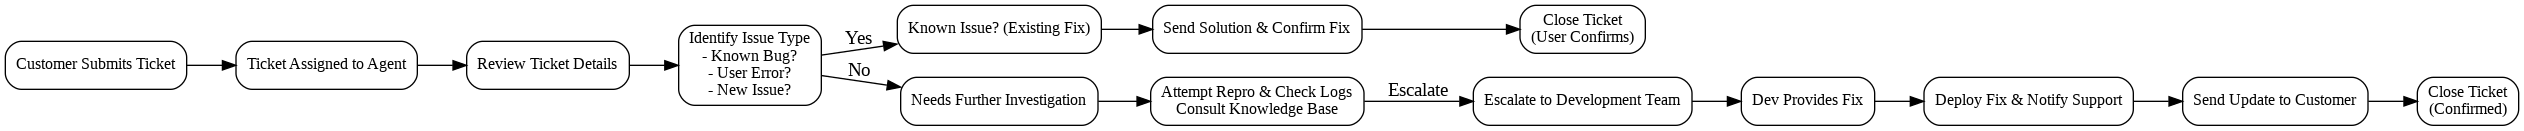

In [164]:
from PIL import Image
Image.open("workflow_diagram.png")

## Backend building (30 minutes)

Use LlamaIndex agents to build out your agent.
Your goal over the next 30 minutes is to:
- Create (or import) any tools you need to accomplish your goal.
- Create your agent using one of the agent classes provided by LlamaIndex.
- Create 2-3 test cases and check your agent against them to see if it produces the desired output.

In [2]:
user_docs = """
# AerisApp User Documentation

Welcome to AerisApp, your cloud-based project management tool. This guide helps you troubleshoot and resolve common issues.

---

## Table of Contents
1. [Unable to Log In](#unable-to-log-in)
2. [Missing or Incomplete Data](#missing-or-incomplete-data)
3. [Slow Performance](#slow-performance)
4. [Notifications Not Sending or Receiving](#notifications-not-sending-or-receiving)
5. [Error Messages](#error-messages)

---

## Unable to Log In

### Steps to Resolve:
1. **Check Credentials**: Ensure your email and password are correct.
2. **Reset Password**: Click the **"Forgot Password?"** link on the login page and follow the instructions.
3. **Browser Compatibility**: Ensure you are using a supported browser (Chrome, Firefox, Safari, or Edge). If issues persist, switch browsers.

---

## Missing or Incomplete Data

### Steps to Resolve:
1. **Refresh Your Page**: Use `Ctrl + F5` (Windows) or `Cmd + Shift + R` (Mac) to perform a hard refresh.
2. **Check Filters**: Verify that your filters are not hiding the tasks you’re looking for.
3. **Confirm Permissions**: If data is missing, you might not have the right permissions. Contact your workspace administrator.

---

## Slow Performance

### Steps to Resolve:
1. **Close Unused Tabs**: Reduce the number of open browser tabs.
2. **Clear Cache**: Clear your browser cache to improve speed.
3. **Check Network**: Ensure your network is stable. If possible, use a wired connection.

---

## Notifications Not Sending or Receiving

### Steps to Resolve:
1. **Check Notification Settings**: Go to **Settings > Notifications** and confirm that notifications are enabled.
2. **Email Filters**: Check your spam or promotions folder. Add `noreply@aerisapp.com` to your trusted sender list.
3. **Contact Support**: If the problem persists, submit a ticket through the **AerisApp Help Center**.

---

## Error Messages

### Common Error: 500 Internal Server Error
1. **Retry Action**: Wait a few seconds and try again.
2. **Check Status Page**: Visit [AerisApp Status Page](https://status.aerisapp.com) to see if there are any ongoing outages.
3. **Submit a Support Ticket**: If the issue continues, take a screenshot of the error and contact support.

---

## Need Additional Help?

If your issue is not listed here, visit our [Help Center](https://help.aerisapp.com) or contact our support team at `support@aerisapp.com`.
"""

customer_service_docs = """\
# AerisApp Customer Support Documentation

This guide outlines the process for handling customer support tickets to ensure consistent and efficient issue resolution.

---

## Table of Contents
1. [Purpose](#purpose)
2. [Ticket Handling Steps](#ticket-handling-steps)
    - [1. Ticket Review](#1-ticket-review)
    - [2. Initial Response](#2-initial-response)
    - [3. Investigation](#3-investigation)
    - [4. Resolution](#4-resolution)
    - [5. Follow-Up](#5-follow-up)
3. [Support Workflow Diagram](#support-workflow-diagram)

---

## Purpose

The purpose of this document is to guide AerisApp support representatives through the workflow of managing inbound tickets to ensure timely and effective resolutions.

---

## Ticket Handling Steps

### 1. Ticket Review
- **Verify Details**: Ensure the ticket contains necessary information (e.g., user’s email, account ID, problem description).
- **Set Priority**: Confirm or adjust the ticket priority (Low, Medium, High, Critical).

---

### 2. Initial Response
- Respond within the appropriate SLA timeframe.
- Greet the customer by name and acknowledge the issue.
- Provide known solutions or troubleshooting steps, if applicable.

---

### 3. Investigation
- **Check Knowledge Base**: Review internal documentation for related solutions.
- **Test and Reproduce**: Attempt to reproduce the issue in a test environment if necessary.
- **Identify Patterns**: Verify if the issue is part of a known bug or outage.

---

### 4. Resolution
- Provide clear, step-by-step instructions if a known solution exists.
- If escalated internally, keep the user informed on the progress and estimated resolution time.
- Confirm the issue is resolved with the customer before closing the ticket.

---

### 5. Follow-Up
- Send a follow-up survey or invite the customer to rate their experience.
- Update internal documentation to include new solutions or workarounds.
- Ensure any unresolved issues are appropriately escalated.

---

## Support Workflow Diagram

```mermaid
graph LR
    A[Customer Submits Ticket] --> B[Ticket Assigned to Agent]
    B --> C[Review Ticket Details]
    C --> D[Identify Issue Type<br>- Known Bug?<br>- User Error?<br>- New Issue?]
    D -->|Yes| E[Known Issue? (Existing Fix)]
    D -->|No| F[Needs Further Investigation]
    E --> G[Send Solution & Confirm Fix]
    G --> H[Close Ticket (User Confirms)]
    F --> I[Attempt Repro & Check Logs<br>Consult Knowledge Base]
    I --> J[Escalate to Development Team]
    J --> K[Dev Provides Fix]
    K --> L[Deploy Fix & Notify Support]
    L --> M[Send Update to Customer]
    M --> N[Close Ticket (Confirmed)]
```
"""

import os

if not os.path.exists('docs'):
    os.mkdir('docs')
with open('docs/user_docs.md', 'w') as f:
    f.write(user_docs)
with open('docs/customer_service_docs.md', 'w') as f:
    f.write(customer_service_docs)

In [8]:
# Create the query engine tool to answer questions
from llama_index.core.readers import SimpleDirectoryReader
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.tools import FunctionTool, RetrieverTool, QueryEngineTool
from llama_index.core import VectorStoreIndex, Settings
from llama_index.llms.openai import OpenAI

Settings.llm = OpenAI(model="gpt-4o-mini")

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

aeris_docs = SimpleDirectoryReader('docs').load_data()
aeris_nodes = MarkdownNodeParser.from_defaults().get_nodes_from_documents(aeris_docs)
aeris_index = VectorStoreIndex(aeris_nodes, embed_model=embed_model)
aeris_rag_tool = QueryEngineTool.from_defaults(aeris_index.as_query_engine(), name="product_documentation", description="Useful when you want to look up product documentation.")

In [9]:
# Create new unhandled customer tickets
tickets = [
    {
        "title": "Unable to Log In",
        "body": "The user reports being unable to log into their account. They have attempted a password reset, but the email never arrived. Browser: Chrome 116."
    },
    {
        "title": "Task Missing from Dashboard",
        "body": "A task created yesterday is not visible on the user's dashboard. They have confirmed that their filters are set correctly and refreshed the page."
    },
    {
        "title": "Slow Performance in Task Loading",
        "body": "The user reported that tasks were taking over 30 seconds to load. The issue was resolved by clearing their browser cache."
    },
    {
        "title": "Error 500 on Project Creation",
        "body": "A user encountered a 500 Internal Server Error when attempting to create a new project. The issue could not be reproduced on a test account and has been escalated to the development team."
    },
    {
        "title": "Notifications Not Sending",
        "body": "The user reported not receiving email notifications for task updates. Support has confirmed the user's notification settings were incorrect and updated them. Awaiting confirmation from the user."
    }
]

In [13]:
# Create a database of tickets with statuses (dataframe for now)
tickets_db = [
    {
        "id": 1,
        "title": "Unable to Log In",
        "status": "New",
        "body": "The user reports being unable to log into their account. They have attempted a password reset, but the email never arrived.",
        "created_at": "2024-12-07T10:15:00",
        "updated_at": "2024-12-07T10:15:00",
        "priority": "High"
    },
    {
        "id": 2,
        "title": "Task Missing from Dashboard",
        "status": "In Progress",
        "body": "A task created yesterday is not visible on the user's dashboard. They have confirmed that their filters are set correctly and refreshed the page.",
        "created_at": "2024-12-06T15:30:00",
        "updated_at": "2024-12-07T09:00:00",
        "priority": "Medium"
    },
    {
        "id": 3,
        "title": "Slow Performance in Task Loading",
        "status": "Resolved",
        "body": "The user reported that tasks were taking over 30 seconds to load. The issue was resolved by clearing their browser cache.",
        "created_at": "2024-12-05T14:45:00",
        "updated_at": "2024-12-06T10:15:00",
        "priority": "Low"
    },
    {
        "id": 4,
        "title": "Error 500 on Project Creation",
        "status": "Resolved",
        "body": "A user encountered a 500 Internal Server Error when attempting to create a new project. The issue could not be reproduced on a test account and has been escalated to the development team.",
        "created_at": "2024-12-04T11:00:00",
        "updated_at": "2024-12-07T08:30:00",
        "priority": "Critical"
    },
    {
        "id": 5,
        "title": "Notifications Not Sending",
        "status": "In progress",
        "body": "The user reported not receiving email notifications for task updates. Support has confirmed the user's notification settings were incorrect and updated them. Awaiting confirmation from the user.",
        "created_at": "2024-12-05T09:15:00",
        "updated_at": "2024-12-06T16:45:00",
        "priority": "Medium"
    },
    {
        "id": 6,
        "title": "Duplicate Tasks Created",
        "status": "New",
        "body": "A user reports that adding a task occasionally creates duplicate entries in the task list.",
        "created_at": "2024-12-07T11:30:00",
        "updated_at": "2024-12-07T11:30:00",
        "priority": "Low"
    },
    {
        "id": 7,
        "title": "Project Sharing Not Working",
        "status": "New",
        "body": "A user reports that shared projects are not visible to other users, even after granting access.",
        "created_at": "2024-12-05T13:00:00",
        "updated_at": "2024-12-06T14:00:00",
        "priority": "High"
    },
    {
        "id": 8,
        "title": "Mobile App Crashes on Task Creation",
        "status": "Resolved",
        "body": "A user reported that the mobile app crashed while creating a task. The issue was resolved with the latest app update.",
        "created_at": "2024-12-01T10:00:00",
        "updated_at": "2024-12-03T17:00:00",
        "priority": "Medium"
    },
    {
        "id": 9,
        "title": "Search Function Returning Incorrect Results",
        "status": "In Progress",
        "body": "The user reports that searching for tasks by name sometimes returns irrelevant results.",
        "created_at": "2024-12-06T08:45:00",
        "updated_at": "2024-12-07T10:45:00",
        "priority": "Medium"
    },
    {
        "id": 10,
        "title": "Unable to Upload Files",
        "status": "New",
        "body": "The user cannot upload files to tasks. Error logs indicate a permissions issue.",
        "created_at": "2024-12-02T09:30:00",
        "updated_at": "2024-12-06T12:30:00",
        "priority": "Critical"
    }
]

from llama_index.core.schema import Document
from datetime import datetime

class TicketDB:
    def __init__(self, tickets=tickets_db):
        self.tickets = tickets_db
        self.index = self._build_index()

    def _build_index(self):
        ticket_docs = [
            Document(doc_id=str(t["id"]), text=t["body"], extra_info = {k:v for k, v in t.items() if k not in ['body']}) for t in self.tickets
        ]
        index = VectorStoreIndex.from_documents(ticket_docs, embed_model=embed_model)
        return index


    def new_ticket(self, title:str, body:str, priority:str):
        """
        Add a new ticket to the database.

        Args:
            title (str): The title of the ticket.
            body (str): The body of the ticket.
            priority (str): The priority of the ticket.
        """
        _ticket = {
            "id": len(self.tickets) + 1,
            "title": title,
            "status": "New",
            "body": body,
            "created_at": datetime.now().isoformat(),
            "updated_at": datetime.now().isoformat(),
            "priority": priority
        }
        self.tickets.append(_ticket)
        self.index = self._build_index()
        return "Ticket created successfully"

    def resolve_ticket(self, id: int) -> str:
        """
        Set the status of a ticket to "Resolved".

        Args:
            id (int): The ID of the ticket to resolve.
        """
        for t in self.tickets:
            if t["id"] == id:
                t["status"] = "Resolved"
                t['updated_at'] = datetime.now().isoformat()
                break
        self.index = self._build_index()
        return "Ticket resolved successfully"


    def set_ticket_in_progress(self, id:int) -> None:
        """
        Set the status of a ticket to "In Progress".

        Args:
            id (int): The ID of the ticket to set to "In Progress".
        """
        for t in self.tickets:
            if t["id"] == id:
                t["status"] = "In Progress"
                t['updated_at'] = datetime.now().isoformat()
                break
        self.index = self._build_index()
        return "Ticket set to In Progress successfully"


    @property
    def index_tool(self):
        return RetrieverTool.from_defaults(self.index.as_retriever(), name='ticket_search_tool', description="Useful when you want to look up existing tickets and their statuses.")

    @property
    def resolve_ticket_tool(self):
        return FunctionTool.from_defaults(fn=self.resolve_ticket, description='Useful when you want to close a ticket')

    @property
    def new_ticket_tool(self):
        return FunctionTool.from_defaults(fn=self.new_ticket, description='Useful when you want to create a new ticket')

    def get_tool_list(self):
        return [self.index_tool, self.resolve_ticket_tool, self.new_ticket_tool]

In [19]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get("OPENAI_API_KEY")

In [20]:
from llama_index.agent.openai import OpenAIAgent

db = TicketDB()
tools = db.get_tool_list() + [aeris_rag_tool]
system_prompt = """\
You are an expert at handling customer tickets. \
When you receive a new ticket, first check if a matching issue exists that matches the customer's complaint.
If one doesn't exist, create a new ticket.
If there's an existing ticket that's in progress for the case, communicate the status of the ticket and assure them that they'll be notified when it's done.
If the ticket is resolved, communicate the status to the customer.
If product documentation is available, suggest a course of action to the customer.
"""
ticket_agent = OpenAIAgent.from_tools(tools, llm=OpenAI('gpt-4o-mini'), verbose=True, system_prompt=system_prompt)

In [21]:
ticket_agent.chat(str(tickets[0]))

Added user message to memory: {'title': 'Unable to Log In', 'body': 'The user reports being unable to log into their account. They have attempted a password reset, but the email never arrived. Browser: Chrome 116.'}
=== Calling Function ===
Calling function: ticket_search_tool with args: {"input":"Unable to Log In"}
Got output: id = 1
title = Unable to Log In
status = New
created_at = 2024-12-07T10:15:00
updated_at = 2024-12-07T10:15:00
priority = High
The user reports being unable to log into their account. They have attempted a password reset, but the email never arrived.

id = 10
title = Unable to Upload Files
status = New
created_at = 2024-12-02T09:30:00
updated_at = 2024-12-06T12:30:00
priority = Critical
The user cannot upload files to tasks. Error logs indicate a permissions issue.



=== Calling Function ===
Calling function: new_ticket with args: {"title":"Unable to Log In","body":"The user reports being unable to log into their account. They have attempted a password reset, b

AgentChatResponse(response='A new ticket has been created for the issue titled "Unable to Log In." The user reports being unable to log into their account and has attempted a password reset, but the email never arrived. \n\nIf you need further assistance or updates, feel free to ask!', sources=[ToolOutput(content='id = 1\ntitle = Unable to Log In\nstatus = New\ncreated_at = 2024-12-07T10:15:00\nupdated_at = 2024-12-07T10:15:00\npriority = High\nThe user reports being unable to log into their account. They have attempted a password reset, but the email never arrived.\n\nid = 10\ntitle = Unable to Upload Files\nstatus = New\ncreated_at = 2024-12-02T09:30:00\nupdated_at = 2024-12-06T12:30:00\npriority = Critical\nThe user cannot upload files to tasks. Error logs indicate a permissions issue.\n\n', tool_name='ticket_search_tool', raw_input={'input': '\ninput is Unable to Log In\n'}, raw_output=[NodeWithScore(node=TextNode(id_='335db8c0-c894-4638-b324-f2756cc2a5ad', embedding=None, metadata

In [222]:
len(db.tickets)

11

In [226]:
ticket_agent.chat(str(tickets[1]))

Added user message to memory: {'title': 'Task Missing from Dashboard', 'body': "A task created yesterday is not visible on the user's dashboard. They have confirmed that their filters are set correctly and refreshed the page."}
=== Calling Function ===
Calling function: ticket_search_tool with args: {"input":"Task Missing from Dashboard"}
Got output: id = 2
title = Task Missing from Dashboard
status = In Progress
created_at = 2024-12-06T15:30:00
updated_at = 2024-12-07T09:00:00
priority = Medium
A task created yesterday is not visible on the user's dashboard. They have confirmed that their filters are set correctly and refreshed the page.

id = 6
title = Duplicate Tasks Created
status = New
created_at = 2024-12-07T11:30:00
updated_at = 2024-12-07T11:30:00
priority = Low
A user reports that adding a task occasionally creates duplicate entries in the task list.





AgentChatResponse(response='There is an existing ticket titled "Task Missing from Dashboard" that is currently in progress. The issue involves a task created yesterday that is not visible on the user\'s dashboard, and they have confirmed that their filters are set correctly and have refreshed the page.\n\nRest assured, you will be notified once the issue is resolved. If you have any further questions or need assistance, feel free to ask!', sources=[ToolOutput(content="id = 2\ntitle = Task Missing from Dashboard\nstatus = In Progress\ncreated_at = 2024-12-06T15:30:00\nupdated_at = 2024-12-07T09:00:00\npriority = Medium\nA task created yesterday is not visible on the user's dashboard. They have confirmed that their filters are set correctly and refreshed the page.\n\nid = 6\ntitle = Duplicate Tasks Created\nstatus = New\ncreated_at = 2024-12-07T11:30:00\nupdated_at = 2024-12-07T11:30:00\npriority = Low\nA user reports that adding a task occasionally creates duplicate entries in the task 

## Frontend building (15 minutes)

Your goal over the next 15 minutes is to:
- Use `gradio` to build an interface for your agent.
- Test your agent with 2-3 different inputs to ensure it's working as expected.
- If you want to use your agent more like an api, check out the [`gradio-client`](https://www.gradio.app/docs/python-client/introduction) library and run your test cases programmatically.

In [22]:
import gradio as gr

In [23]:
system_prompt = """\
You are an expert at handling customer tickets. \
When you receive a new ticket, first check if a matching issue exists that matches the customer's complaint.
If one doesn't exist, create a new ticket.
If there's an existing ticket that's in progress for the case, communicate the status of the ticket and assure them that they'll be notified when it's done.
If the ticket is resolved, communicate the status to the customer.
If product documentation is available, suggest a course of action to the customer.
"""

def respond(title, body, db:TicketDB):
    db_tools = db.get_tool_list()
    tools = db_tools + [aeris_rag_tool]
    agent = OpenAIAgent.from_tools(tools, llm='gpt-4o-mini', verbose=False, system_prompt=system_prompt)
    return agent.chat(str(dict(title=title, body=body))).response


In [26]:
with gr.Blocks() as demo:
    _db = gr.State(value=TicketDB())
    gr.Markdown("## Submit a new ticket")
    title = gr.Textbox(placeholder='Title your ticket', interactive=True)
    body = gr.Textbox(placeholder="Describe your ticket, including anything you've tried", interactive=True)
    with gr.Row():
        submit = gr.Button("Submit")
        clear = gr.Button('Clear')
    response = gr.TextArea()

    submit.click(respond, inputs=[title, body, _db], outputs=[response])
    clear.click(lambda: (None, None, None), [title, body, response])

demo.launch()

/usr/local/lib/python3.10/dist-packages/gradio/utils.py:999: UserWarning: Expected 0 arguments for function <function <lambda> at 0x7b38c862dea0>, received 3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1007: UserWarning: Expected maximum 0 arguments for function <function <lambda> at 0x7b38c862dea0>, received 3.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://28df1834e4e9903e96.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [25]:
tickets[2]

{'title': 'Slow Performance in Task Loading',
 'body': 'The user reported that tasks were taking over 30 seconds to load. The issue was resolved by clearing their browser cache.'}

In [29]:
import numpy as np
np.random.choice([
    'LIsa', 'Leena', 'PJ', "Kseniya", "Gustavo", "Mukta", "Terence", "Eric"
])

'LIsa'